In [1]:
import emcee
import torch
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt 
import random 
from getdist import plots, MCSamples
import getdist

# our scripts and functions
from src.gp.gaussianprocess import GaussianProcess
import src.cosmofuncs as cf
import src.model as sm
import src.compression as sc 
import src.optimisation as so
import utils.helpers as hp
import setting as st

settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3}

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

In [2]:
model = sm.AppMag(load_data=True)

# Compression

In [3]:
comp = sc.moped(load_data = True)
moped_vectors = comp.vectors(model.mle)

0 0 :  1.0000
1 0 : -0.0000
1 1 :  1.0000
2 0 :  0.0000
2 1 :  0.0000
2 2 :  1.0000
3 0 : -0.0000
3 1 : -0.0000
3 2 : -0.0000
3 3 :  1.0000
4 0 :  0.0000
4 1 : -0.0000
4 2 : -0.0000
4 3 :  0.0000
4 4 :  1.0000
5 0 :  0.0000
5 1 : -0.0000
5 2 : -0.0000
5 3 : -0.0000
5 4 : -0.0000
5 5 :  1.0000


# Emulation

We will emulate the MOPED coefficients. 

In [4]:
num = 1000
csv = pd.read_csv('simulations/simulations_'+str(num)+'.csv')
mopedcoeffs = csv[[f'exact_{i+1}' for i in range(6)]]

In [5]:
# these are the cosmological and nuisance parameters
inputs = torch.from_numpy(csv.iloc[:,0:6].values)

niter = 500
lr = 0.01
nrestart = 3 

In [6]:
gp_moped = {}
eps = [1E-15]*6
for i in range(6):
    # this is the i^th MOPED coefficient
    output = torch.from_numpy(mopedcoeffs.iloc[:,i].values)
    
    # train the GP
    GP_module = GaussianProcess(inputs, output, eps[i], xtrans=True, ytrans=True)
    start = torch.randn((inputs.shape[1]+1,))
    optimum = GP_module.optimisation(parameters = start, niter = niter, l_rate=lr, nrestart = nrestart)
    gp_moped[f'gp_{i+1}'] = GP_module

# Test Prediction

In [7]:
param = torch.tensor([0.15, -1.0, -19.04, -0.04, 0.125, 2.60])

In [8]:
theory = model.theory_only(param)

In [9]:
comp.compute_coefficients(theory)

tensor([-1.1648e+03, -5.4407e+02,  6.9902e+02,  8.8756e-01,  1.4377e+01,
         3.2957e+01])

In [10]:
torch.cat([gp_moped[f'gp_{i+1}'].mean_prediction(param).data for i in range(6)])

tensor([-1.1648e+03, -5.4407e+02,  6.9902e+02,  8.8664e-01,  1.4378e+01,
         3.2969e+01], dtype=torch.float64)

# Accuracy Test

- Sample a few points from the prior. 
- Compute the MOPED coefficients. 
- Calculate the accuracy for each emulator.

$$
A = \dfrac{\mu - \mu_{\textrm{emu}}}{\mu} \times 100
$$

In [11]:
import src.trainingpoints as stp

In [12]:
module = stp.simulations(load_data = True, nlhs = num)

In [13]:
priors = module.distributions(1.0)

In [14]:
ntest = 1000

In [15]:
samples_om = priors['p0'].rsample(torch.Size([ntest])).numpy().reshape(ntest, 1)
samples_w0 = priors['p1'].rsample(torch.Size([ntest])).numpy().reshape(ntest, 1)
samples_nuisance = priors['p_nuisance'].rsample(torch.Size([ntest])).numpy().reshape(ntest, 4)

In [16]:
testpoints = np.concatenate([samples_om, samples_w0, samples_nuisance], axis = 1)

In [17]:
# calculate the theory first 
record_theory = []
record_gp_theory = []
for i in range(ntest):
    param = torch.from_numpy(testpoints[i])
    theory_test = model.theory_only(param)
    record_theory.append(comp.compute_coefficients(theory_test).numpy())
    
    theory_gp = torch.cat([gp_moped[f'gp_{i+1}'].mean_prediction(param).data for i in range(6)])
    record_gp_theory.append(theory_gp.numpy())

In [18]:
record_theory = np.asarray(record_theory)
record_gp_theory = np.asarray(record_gp_theory)

In [19]:
delta = record_theory - record_gp_theory
accuracy = delta / record_theory 

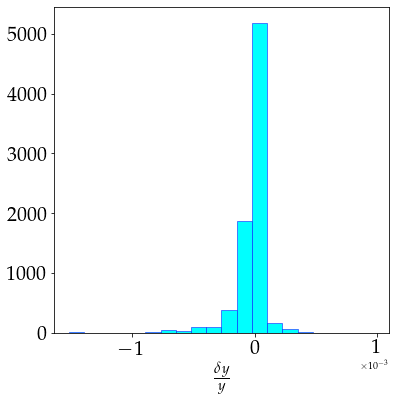

In [20]:
plt.figure(figsize=(6,6))
plt.hist(accuracy[:,0], density=True, bins = 20, color = 'cyan', edgecolor='blue', linewidth=0.5)
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,4))
plt.xlabel(r'$\frac{\delta y}{y}$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

# MCMC

To couple emulator with MCMC routine. 

In [21]:
comp_data = comp.compute_coefficients(comp.data_vec)
use_gp = True

In [22]:
def emcee_lnprior(parameters):
    """Calculates the log-prior given a set of parameters.

    Args:
        parameters (torch.tensor): the parameters to be used for the prior calculation.

    Returns:
        float: the log-prior.
    """

    logp = priors['p0'].log_prob(parameters[0])
    logp += priors['p1'].log_prob(parameters[1])
    logp += priors['p_nuisance'].log_prob(parameters[2:])
    logp = logp.numpy()

    return logp

In [23]:
def emcee_loglike(parameters):

    """Calculates the log-likelihood given a set of parameters.

    Args:
        parameters (np.ndarray): the parameters to be used for the likelihood calculation.

    Returns:
        float: the log-likelihood.
    """

    # calculates the log-prior and exclude point if the parameter is not within the prior
    params = torch.from_numpy(parameters)
    logp = emcee_lnprior(params)
    if use_gp:
        mean = torch.cat([gp_moped[f'gp_{i+1}'].mean_prediction(params).data for i in range(6)])
    else:
        theory = model.theory_only(params)
        mean = comp.compute_coefficients(theory).numpy()
    dist = torch.distributions.multivariate_normal.MultivariateNormal(mean, torch.eye(6))
    logl = dist.log_prob(comp_data).numpy()
    return logp.item(), logl.item()

In [24]:
def emcee_lnpost(parameters):
    if np.any(np.isinf(parameters)) or np.any(np.isnan(parameters)):
        return -1E32
    else:
        logprior, loglike = emcee_loglike(parameters)
        logpost = logprior + loglike
        if np.isfinite(logpost):
            return logpost
    return -1E32

In [25]:
initial = comp.mle.numpy()
nparams = 6
eps = 1E-4 
pos = initial.reshape(1, nparams) +  eps * np.random.normal(size = (2*nparams, nparams))
nwalkers, ndim = pos.shape

In [26]:
nsamples = 10000
iter_number = 1

In [27]:
sampler_1 = emcee.EnsembleSampler(nwalkers, ndim, emcee_lnpost)
sampler_1.run_mcmc(pos, nsamples, progress=True);

100%|██████████| 10000/10000 [04:31<00:00, 36.80it/s]


In [28]:
sampler_2 = emcee.EnsembleSampler(nwalkers, ndim, emcee_lnpost)
sampler_2.run_mcmc(pos, nsamples, progress=True);

100%|██████████| 10000/10000 [04:19<00:00, 38.47it/s]


In [29]:
RANGES = {'x0':(0.0, None), 
          'x4':(0.11, 0.14),
          'x5': (2.4, 2.8)}

In [30]:
burnin  = 100
ndim     = 6
names    = ["x%s"%i for i in range(ndim)]
labels   =  [r'$\Omega_{m}$', r'$w_{0}$', r'$M_{B}$', r'$\delta M$', r'$\alpha$', r'$\beta$']

samples_1 = sampler_1.chain[:, burnin:, :].reshape((-1, ndim))
cut_samps = samples_1[samples_1[:,0]>=0.0,:]
samples1= MCSamples(samples=cut_samps, names = names, labels = labels, 
                    ranges=RANGES, settings=settings, label='MCMC 1')

Removed no burn in


In [31]:
samples_2 = sampler_2.chain[:, burnin:, :].reshape((-1, ndim))
cut_samps = samples_2[samples_2[:,0]>=0.0,:]
samples2= MCSamples(samples=cut_samps, names = names, labels = labels, 
                    ranges=RANGES, settings=settings, label='MCMC 2')

Removed no burn in


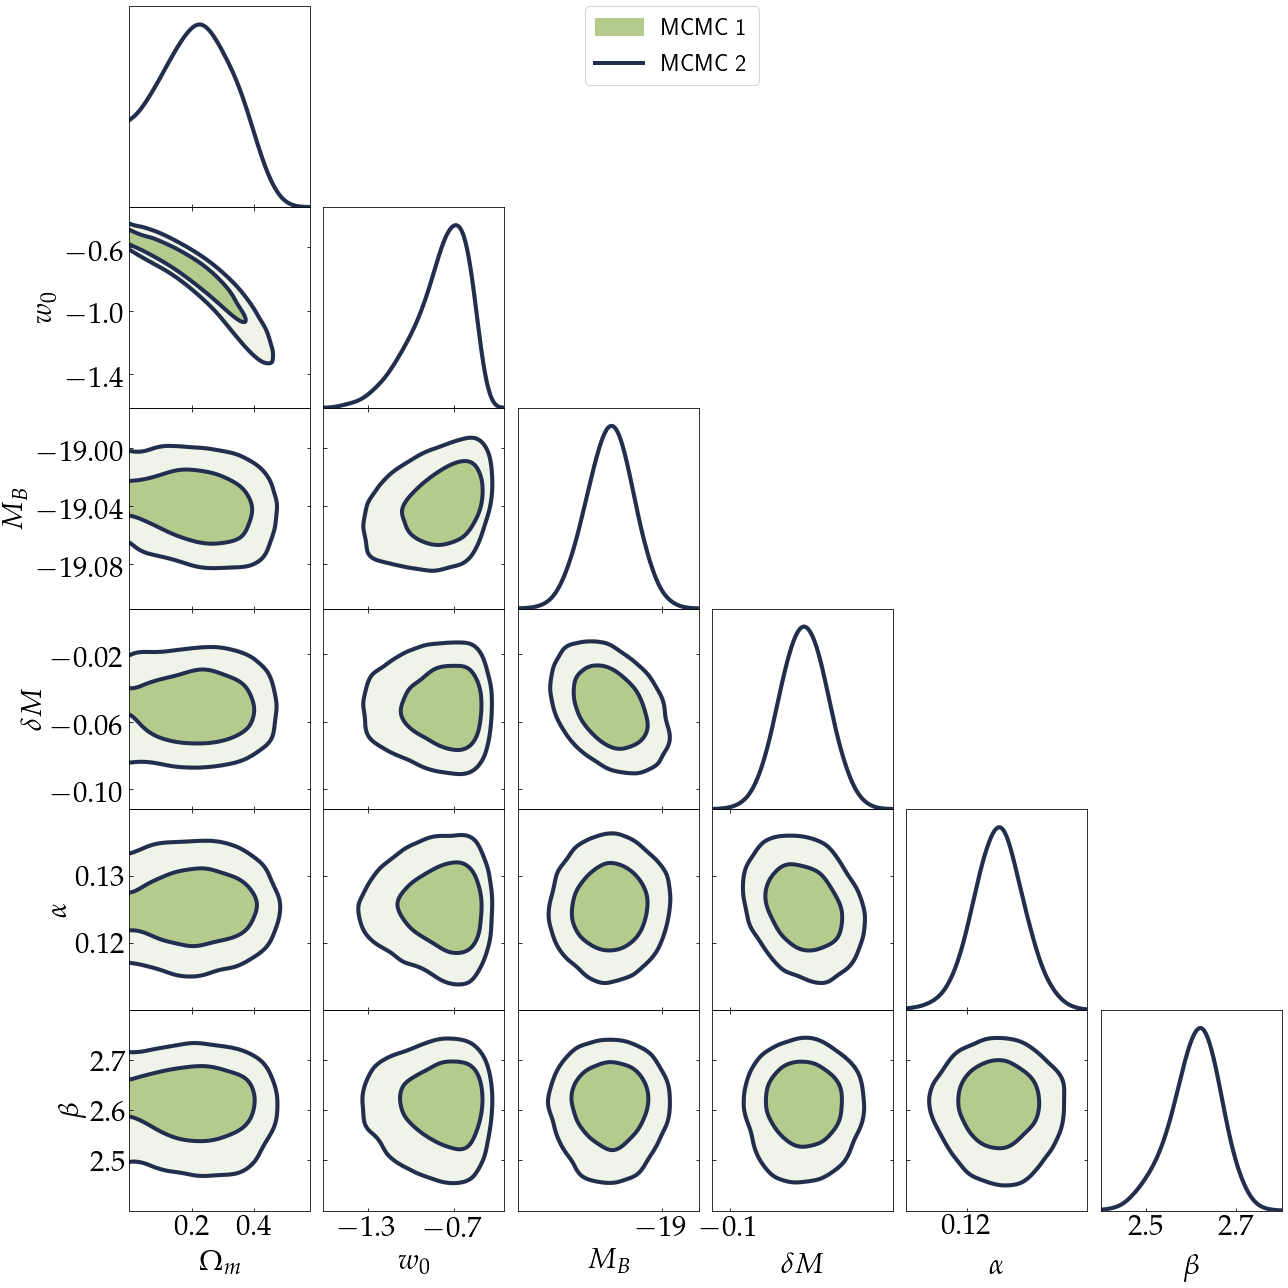

In [32]:
c1 = '#B5CA8D'
c3 = '#222E50'
alpha = 0.7
contours = np.array([0.68,0.95])

G = plots.getSubplotPlotter(subplot_size=3)
G.settings.solid_contour_palefactor = 0.8
G.settings.alpha_filled_add = alpha
G.settings.num_plot_contours = 2
G.settings.lw_contour = 5
G.settings.axes_fontsize = 30
G.settings.lab_fontsize = 30
G.settings.fontsize = 35 # important for padding in x-axis 
G.settings.legend_fontsize = 25
samples1.updateSettings({'contours': [0.68, 0.95]})
samples2.updateSettings({'contours': [0.68, 0.95]})
G.triangle_plot([samples1, samples2], filled = [True, False], contour_colors=[c1, c3], contour_lws=[4, 4], contour_ls=['-', '-'])
# plt.savefig('plots/triangle_plot_'+sample_name+'.pdf', transparent = False, bbox_inches = 'tight') 
plt.show()